In [1]:
%load_ext autoreload
%autoreload 2
import os
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test/src")

# from model import EF
# from loss import dipole_calc
# from  training import train_model # from model import dipole_calc
import jax
import optax
import e3x

# from dcmnet.analysis import create_model_and_params
# from data import prepare_batches, prepare_datasets
import numpy as np

from physnetjax.model import EF
from physnetjax.loss import dipole_calc
from  physnetjax.training import train_model # from model import dipole_calc
from physnetjax.data import prepare_batches, prepare_datasets


import orbax
from orbax.checkpoint import PyTreeCheckpointer
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [17]:
from pathlib import Path

restart_dir_base = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts")
restart_dir = restart_dir_base / "cf3all-d58b8698-f2b6-4b53-bb12-337b2bf70459"
restart_dir = restart_dir_base / "cf3all-74f8f50d-f2d1-4538-8016-19905047ec58"
# path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/adp-1c07d6ad-7a43-4cf6-afd2-f9c76ff0ce7b")
path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/aaa-ec3e940b-642e-4558-b670-a3c10bb33176")
# path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/test-4fd66a4e-1c54-484e-a7b6-52fca8cb23d3")
path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/aaa1-0b2547d6-a0b2-4c0e-be28-555f40de9bd2")
path = restart_dir_base / "cf3all-d58b8698-f2b6-4b53-bb12-337b2bf70459"

In [18]:
files = list(path.glob("*"))
files.sort()

In [19]:
# from orbax.checkpoint import PyTreeRestoreArgs

# restore_args = PyTreeRestoreArgs()  # Adjust arguments as needed
# restored = orbax_checkpointer.restore(path / "epoch-1", args=restore_args)
epochs = []
lr_effs = []
restored_objectives = []

for _ in files[-10:]:
    re = orbax_checkpointer.restore(_)
    epochs.append(int(re["epoch"]))
    lr_effs.append(float(re["lr_eff"]))
    restored_objectives.append(re["objectives"])


/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [20]:
import pandas as pd

df = pd.DataFrame({"epoch": epochs, 
             "lr": lr_effs,
             "train_energy_mae": [float(_["train_energy_mae"]) for _ in restored_objectives],
             "train_forces_mae": [float(_["train_forces_mae"]) for _ in restored_objectives],
              "valid_energy_mae": [float(_["valid_energy_mae"]) for _ in restored_objectives],
              "valid_forces_mae": [float(_["valid_forces_mae"]) for _ in restored_objectives],
             })

,epoch,lr,train_energy_mae,train_forces_mae,valid_energy_mae,valid_forces_mae
1,8,0.000851,44.884773,11.127794,28.595440,10.577998
4,9,0.000885,42.027916,10.659142,28.817499,10.359525
0,79,0.000333,28.851768,5.997447,11.135901,5.386427
2,80,0.000333,23.163544,5.891715,11.389669,5.368294
3,82,0.000333,31.438175,6.046812,11.666702,5.339243
5,91,0.000333,24.839218,5.846608,11.052705,5.335332
6,93,0.000333,25.481018,5.798274,12.662103,5.289190
7,95,0.000333,32.459961,5.932800,13.044623,5.226970
8,97,0.000333,23.162024,5.770459,11.409904,5.225732
9,98,0.000333,27.988262,5.766822,11.890218,5.211305


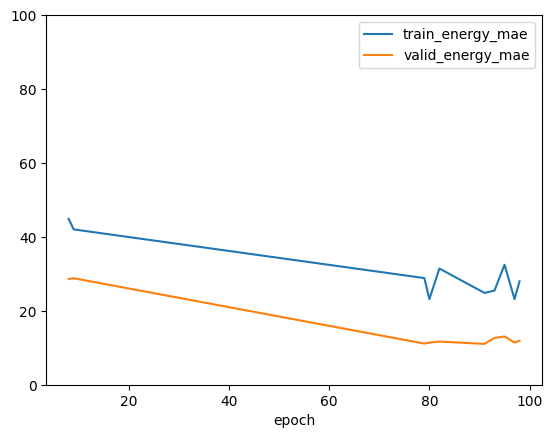

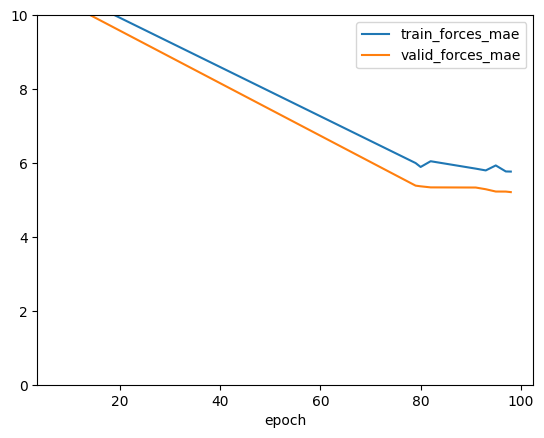

In [21]:
df = df.sort_values(by="epoch")
import matplotlib.pyplot as plt
df.plot("epoch", ["train_energy_mae", "valid_energy_mae"])
plt.ylim(0,100)
df.plot("epoch", ["train_forces_mae", "valid_forces_mae"])
plt.ylim(0,10)
df

In [5]:
data_key, train_key = jax.random.split(
    jax.random.PRNGKey(43), 2)
NATOMS = 8
files = ["/pchem-data/meuwly/boittier/home/all.npz"]
train_data, valid_data = prepare_datasets(data_key, 27030, 2000,
                                          files, 
                                          clip_esp=False, natoms=NATOMS, clean=False)

2024-12-05 08:17:33.286512: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


shape (29030, 8, 3) not failed [    0     1     2 ... 29027 29028 29029]
dataR (29030, 8, 3)
D (29030, 3)
Q 1 (29030,) 29030
Q (29030,)
R (29030, 8, 3)
(29030, 8, 3)
['R', 'Z', 'F', 'E', 'N', 'D', 'Q']
29030
0 R 29030 (29030, 8, 3)
1 Z 29030 (29030, 8)
2 F 29030 (29030, 8, 3)
3 E 29030 (29030, 1)
4 N 29030 (29030, 1)
5 D 29030 (29030, 3)
6 Q 29030 (29030,)


In [6]:
ntest = len(valid_data["E"]) // 2
print(ntest)
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}


1000


In [7]:
model = EF(
    # attributes
    features = 128,
    max_degree = 0,
    num_iterations = 5,
    num_basis_functions = 64,
    cutoff = 10.0,
    max_atomic_number = 12,
    charges = True,
    natoms=NATOMS,
    total_charge=0,
    n_res=4,
    zbl=True,
    # debug=["ele", "dist", "idx"],
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 12
    charges = True
    natoms = 8
    total_charge = 0
    n_res = 4
    zbl = True
    debug = False
)

In [10]:
import pandas as pd


data_keys = ["R", "Z", "F", "E", "D", "N", "dst_idx", "src_idx", "batch_segments"]

batch_size = 100
test_batches = prepare_batches(data_key, test_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

# train_batches = prepare_batches(data_key, train_data, batch_size,
#                               num_atoms=NATOMS, 
#                               data_keys=data_keys)

valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

# params = pd.read_pickle("/pchem-data/meuwly/boittier/home/pycharmm_test/checkpoints/diox-q3.2.pkl")
# for _ in test_batches[0].keys():
#     print(_, test_batches[0][_].shape)
valid_batches

[{'R': array([[-0.51447905,  0.00672075,  0.03363383],
         [ 0.98158616, -0.12503166,  0.04463793],
         [ 1.52093228,  1.07743144,  0.06037832],
         ...,
         [-0.65160858, -0.06952701,  1.34179548],
         [-1.22368314,  1.17109838, -0.29928934],
         [ 0.81892107,  0.17181456, -1.62207719]]),
  'Z': array([6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9,
         9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8,
         9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6,
         8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1,
         6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9,
         9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8,
         9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6,
         8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1,
         6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9, 9, 1, 6, 6, 8, 8, 9, 9,

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-74f8f50d-f2d1-4538-8016-19905047ec58/epoch-1319
The file was last modified on: 2024-12-05 08:26:58.902182
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = 8
    total_charge = 0.0
    n_res = 1
    zbl = True
    debug = []
)


20it [00:20,  1.00s/it]


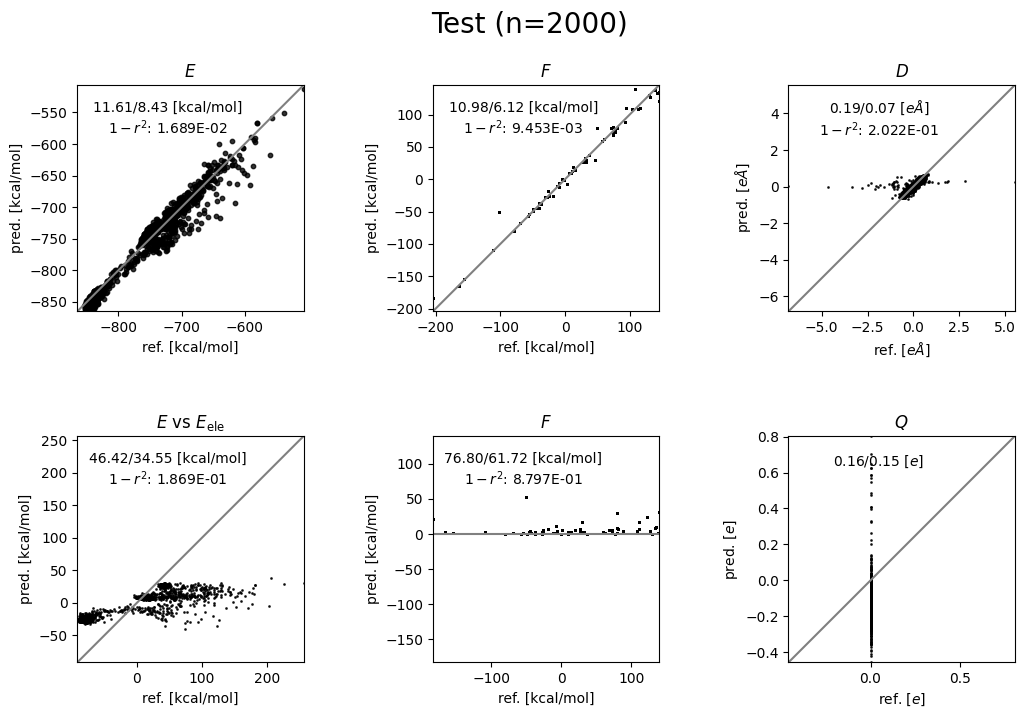

In [26]:
from pathlib import Path
restart_dir_base = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts")
restart_dir = restart_dir_base / "cf3all-d58b8698-f2b6-4b53-bb12-337b2bf70459"
restart_dir = restart_dir_base / "cf3all-74f8f50d-f2d1-4538-8016-19905047ec58"
# restart_dir = restart_dir_base / "test-8eaea815-24ac-43e9-9efd-177d7101c2c5"

from physnetjax.utils import get_last, get_files, get_params_model
from physnetjax.analysis import plot_stats

restart = get_last(restart_dir)
dirs = get_files(restart_dir)
# for _ in test_batches[0].keys():
#     print(_, test_batches[0][_].shape)
        
params,model = get_params_model(restart)
# print(model)
output = plot_stats(test_batches[:]+valid_batches, model, params, _set="Test", 
               do_kde=False, batch_size=batch_size)


In [311]:
list(Path(restart_dir).glob("*"))

[]

In [312]:
dirs = get_files(restart_dir)

In [314]:
help(get_files)

Help on function get_files in module physnetjax.utils:

get_files(path: str) -> List[pathlib.Path]
    Get sorted directory paths excluding tmp directories.

